In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import euclidean_distances
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import Normalizer, StandardScaler

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score

def scores(y, y_pred):
    conf_mat = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
    conf_mat.plot()
    RocCurveDisplay.from_predictions(y, y_pred)
    plt.show()
    print(f"Accuracy tests: {accuracy_score(y, y_pred)}")
    print(f"Precision tests: {precision_score(y, y_pred)}")
    print(f"Recall tests: {recall_score(y, y_pred)}")

In [50]:
class Linear(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-03, epoch=1, batch_size=64):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
    
    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(-x))
        return self.l
        
    def fit(self, X, y):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(X[0]),))
        
        for i in range(self.epoch):
            for i in range(0, len(X), self.batch_size):
                xb = X[i:i + self.batch_size]
                yb = y[i:i + self.batch_size]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp

    def predict(self, x):
        p = self.predict_proba(x)
        return (p > 0.5).astype('int64')

    def predict_proba(self, x):
        x = np.concatenate((x, np.ones((x.shape[0],1))), axis = 1)
        p = np.dot(self.W, x.T)

        return self.sigmoid(p)

In [40]:
class KNeighbors(BaseEstimator, ClassifierMixin):
    
    def __norm(self, x, y):
        return np.sqrt(np.sum(np.square(x - y)))
    
    def __init__(self, **kwargs):
        self.k = kwargs.get('k', 5)
        self.data = None
        
    def predict(self, p):
        result = []
        for x in p:
            self.data.sort(key = lambda t : self.__norm(t[0], x))
            result.append(np.bincount(np.array([i[1] for i in self.data[:self.k]])).argmax())
        return np.array(result)
    
    def predict_proba(self, p):
        result = []
        for x in p:
            self.data.sort(key = lambda t : self.__norm(t[0], x))
            res = np.bincount(np.array([i[1] for i in self.data[:self.k]]), minlength=2)[1] / self.k
            result.append(res)
        return np.array(result)
    
    def fit(self, Train_data, Train_labels):
    
        self.data = [(Train_data[i], Train_labels[i]) for i in range(len(Train_data))]
        return self
    
    def get_params(self, deep=True):
        return {"k": self.k}

In [63]:
class SVM(BaseEstimator, ClassifierMixin):
    
    def __sigm(self, x):
        x = np.clip(x, -10, 10)
        return 1.0 / (1.0 + np.exp(-x))
    
    def __init__(self, a = 3, **kwargs):
        self.W = np.random.normal(0, 1, a + 1)
        self.alpha = kwargs.get('alpha', 0.1)
        self.epoch = kwargs.get('epoch', 20)
        self.train_rate = kwargs.get('train_rate', 0.1)
        self.batch = kwargs.get('batch', 4)
        
    def coef(self):
        return self.W
    
    def predict(self, p):
        res = self.predict_proba(p)
        return np.where(res >= 0.5, 1, 0)
    
    def predict_proba(self, p):
        n, m = p.shape
        p = np.c_[np.ones(n), p]
        return self.__sigm(p.dot(self.W))
        
    def fit(self, Train_data, Train_labels):
    
        n, m = Train_data.shape
        Train = np.c_[np.ones(n), Train_data]
    
        for i in range(self.epoch):
            for j in range(0, len(Train), self.batch):
                p = Train[j : j + self.batch]
                y = Train_labels[j : j + self.batch] * 3 - 1
                f_p = self.__sigm(p.dot(self.W))
                
                grad = 2 * self.alpha * self.W
                for ib, xb in enumerate(p):
                    if 1 - xb.dot(self.W) * y[ib] > 0:
                        grad -= xb * y[ib]
                
                self.W -= self.train_rate * grad
                
        return self
    
    def get_params(self, deep=True):
        return {"alpha" : self.alpha, "epoch": self.epoch, "batch": self.batch, "train_rate": self.train_rate}

## load pretrained

In [24]:
with open('best_Linear.pickle', 'rb') as lin_model:
  linear = pickle.load(lin_model)
with open('best_KNN.pickle', 'rb') as knn_model:
  knn = pickle.load(knn_model)
with open('best_SVM.pickle', 'rb') as svm_model:
  svm = pickle.load(svm_model)

In [19]:
df = pd.read_csv('salary.csv')
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
X = pd.get_dummies(df.drop(columns='salary'))
Y = df['salary'].apply(lambda x: 0 if x == ' <=50K' else 1)

x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.25, random_state=22)

In [51]:
'''
linear = Linear()
linear.fit(x_train, y_train)

svm = SVM(a=108)
svm.fit(x_train, y_train)

knn = KNeighbors()
knn.fit(x_train, y_train)
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [83]:
class HardVote(BaseEstimator, ClassifierMixin):
  def __init__(self, estims):
    self.estimators = estims
    
  def fit(self, X, y):
    for model in self.estimators:
      model.fit(X, y)

    return self

  def predict(self, X):
    pred = []
    for model in self.estimators:
      pred.append(model.predict(X))
    
    return stats.mode(np.array(pred)).mode[0]

class SoftVote(BaseEstimator, ClassifierMixin):
  def __init__(self, estims):
    self.estimators = estims
    
  def fit(self, X, y):
    for model in self.estimators:
      model.fit(X, y)

    return self

  def predict(self, X):
    pred = None
    for model in self.estimators:
      if pred is None:
        pred = model.predict_proba(X) / len(self.estimators)
      else:
        pred += model.predict_proba(X) / len(self.estimators)
    
    return (pred >= 0.5)*1

In [84]:
lin_p = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Linear())
])

SVM_p = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVM(a=108))
])

KNN_p = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighbors())
])

hard = HardVote([lin_p, SVM_p, KNN_p]).fit(x_train, y_train)

soft = SoftVote([lin_p, SVM_p, KNN_p]).fit(x_train, y_train)

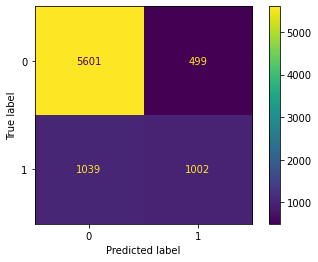

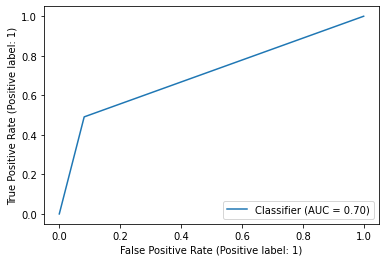

Accuracy tests: 0.8110797199361258
Precision tests: 0.6675549633577615
Recall tests: 0.49093581577658013


In [85]:
scores(y_test, hard.predict(x_test))

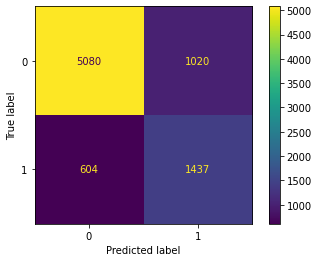

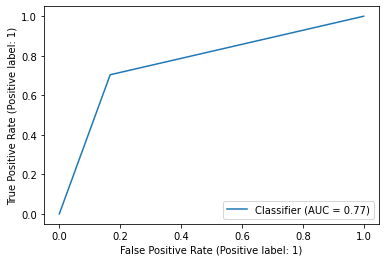

Accuracy tests: 0.8005159071367154
Precision tests: 0.5848595848595849
Recall tests: 0.7040666340029398


In [86]:
scores(y_test, soft.predict(x_test))

In [139]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    
    def __init__(self, **kwargs):
      
      self.siglevel = kwargs.get('siglevel', 0.2)
      self.tree = {}
      self.count = 0
        
    def _gini(self, p):
      return 4 * p * (1 - p)
        
    def fit(self, Train_data, Train_labels):
      features = Train_data.shape[1]
      
      queue = [(0, Train_data, Train_labels, 0)]
      
      while queue:
        idx, Td, Tl, cur_feature = queue.pop(0)
        
        Q = len(Td)
        pq = np.sum(Tl == 0) / Q
        if pq < self.siglevel or pq > 1 - self.siglevel:
          self.tree[idx] = (None, None, Q, pq, None, None)
          continue
            
        minimum = (2, None)
        for x in Td[:, cur_feature]:
          mask = Td[:, cur_feature] <= x
          LTrain = Td[mask]
          LTrainl = Tl[mask]
          RTrain = Td[~mask]
          RTrainl = Tl[~mask]

          L, R = len(LTrainl), len(RTrainl)
          pl, pr = np.sum(LTrainl == 0) / L, np.sum(RTrainl == 0) / R

          Loss = (L/Q + 1)*self._gini(pl) + (R/Q + 1)*self._gini(pr)
          if Loss < minimum[0]:
            minimum = (Loss, x)

        mask = Td[:, cur_feature] <= minimum[1]

        LTrain = Td[mask]
        LTrainl = Tl[mask]
        RTrain = Td[~mask]
        RTrainl = Tl[~mask]
        
        self.tree[idx] = (cur_feature, minimum[1], Q, pq, self.count + 1, self.count + 2)

        queue.append((self.count + 1, LTrain, LTrainl, (cur_feature + 1) % features))
        queue.append((self.count + 2, RTrain, RTrainl, (cur_feature + 1) % features))
        self.count += 2
        cur_feature = (cur_feature + 1) % features
        
      return self
    
    def predict(self, p):
        
      result = []
      
      for x in p:
        iterator = 0
        head = self.tree[iterator]
        
        while not (head[0] is None):
          if x[head[0]] <= head[1]:
            iterator = head[4]
          else:
            iterator = head[5]
          head = self.tree[iterator]
        
        result.append(1 if head[3] <= 0.5 else 0)
      
      return np.array(result)
    
    def predict_proba(self, p):  
      result = []
        
      for x in p:
        iterator = 0
        head = self.tree[iterator]
        
        while not (head[0] is None):
          if x[head[0]] <= head[1]:
            iterator = head[4]
          else:
            iterator = head[5]
          head = self.tree[iterator]
          
        result.append(1 - head[3])
        
      return np.array(result)

In [145]:
dt_p = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTree())
])

dt_p.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


Pipeline(steps=[('scaler', StandardScaler()), ('classifier', DecisionTree())])

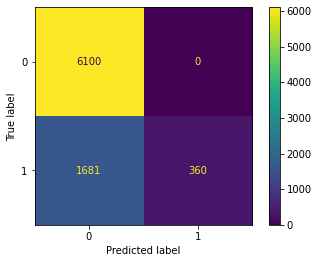

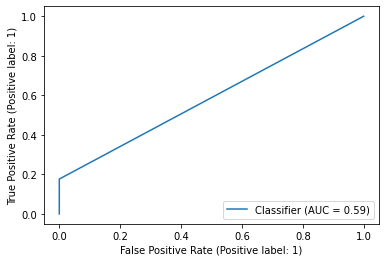

Accuracy tests: 0.7935143102812923
Precision tests: 1.0
Recall tests: 0.1763841254287114


In [146]:
scores(y_test, dt_p.predict(x_test))

In [154]:
class BaggingClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_estimator, **kwargs):
        self.n_estimators = kwargs.get('n_estimators', 10)
        self.max_samples = kwargs.get('max_samples', 10)
        self.pasting = kwargs.get('pasting', False)
        self.models = [base_estimator for _ in range(self.n_estimators)]
        
    def fit(self, Train_data, Train_labels):
        
        for model in self.models:
            if self.pasting:
                random_indices = np.random.choice(len(Train_data), size=self.max_samples, replace=False)
                mask = np.ones(len(Train_data), np.bool)
                mask[random_indices] = 0
                X, y = Train_data[random_indices, :], Train_labels[random_indices]
                Train_data = Train_data[mask, :]
                Train_labels = Train_labels[mask]
            else:
                random_indices = np.random.choice(len(Train_data), size=self.max_samples, replace=False)
                X, y = Train_data[random_indices, :], Train_labels[random_indices]
            model.fit(X, y)
            
        return self
    
    def predict(self, p):
        predicts = []
        for model in self.models:
            predicts.append(model.predict(p))
        return stats.mode(np.array(predicts)).mode[0]

In [166]:
DT_ = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTree())
])

BC = BaggingClassifier(DT_, max_samples = 5, n_estimators = 5).fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


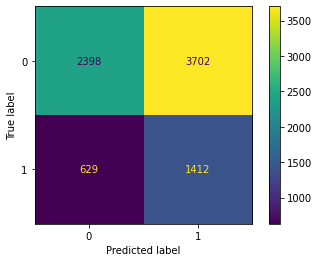

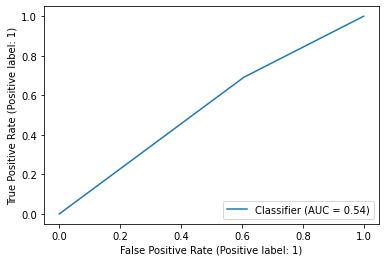

Accuracy tests: 0.4680014740203906
Precision tests: 0.27610481032459916
Recall tests: 0.6918177364037237


In [167]:
scores(y_test, BC.predict(x_test))

In [170]:
from sklearn import tree

In [171]:
skl_dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)

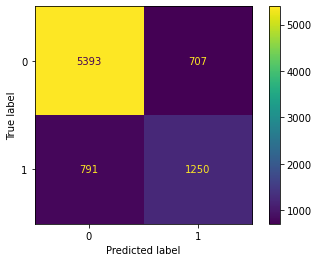

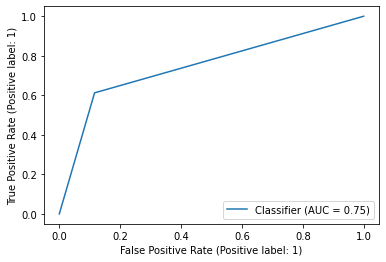

Accuracy tests: 0.8159931212381771
Precision tests: 0.6387327542156361
Recall tests: 0.6124448799608035


In [172]:
scores(y_test, skl_dtc.predict(x_test))